In [11]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import xroms

from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

### Reading CROCO files

In [22]:
pathF='/data/pacific/lrenault/SASI/CROCO/FULL/'
listF=glob(pathF+'surf*.nc');listF.sort()
varF=xr.open_mfdataset(listF[1:],data_vars='minimal')

pathT='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listT=glob(pathT+'surf*SASI_6h_his_20*_*.nc');listT.sort()
listT.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
varT=xr.open_mfdataset(listT[1:],data_vars='minimal')

### Reading WRF files

In [3]:
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
varf=xr.open_mfdataset(listm[-7:])


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
vart=xr.open_mfdataset(listt[-7:])

### Chunks for CROCO and WRF

In [4]:
chunks_croco={'dayofyear':40}
chunks_wrf={'time_counter':40}

In [5]:
%%time
tf_wrf=varf.SST-273.15;
tf_wrf.chunk(chunks=chunks_wrf);
tt_wrf=vart.SST-273.15;
tt_wrf.chunk(chunks=chunks_wrf);

CPU times: user 3.99 ms, sys: 0 ns, total: 3.99 ms
Wall time: 3.83 ms


<xarray.DataArray 'SST' (time_counter: 213, y: 390, x: 300)>
dask.array<rechunk-merge, shape=(213, 390, 300), dtype=float32, chunksize=(40, 390, 300), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(40,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2012-01-01T12:00:00 ... 2012...
Dimensions without coordinates: y, x

In [6]:
%%time
chunks_new={'dayofyear':40}

tf_croco=varF.temp.groupby("time_counter.dayofyear").mean()
tf_croco=tf_croco.chunk(chunks=chunks_new);
tf_croco=tf_croco.compute();

tt_croco=varT.temp.groupby("time_counter.dayofyear").mean()
tt_croco=tt_croco.chunk(chunks=chunks_new);
tt_croco=tt_croco.compute();

CPU times: user 25.8 s, sys: 39.5 s, total: 1min 5s
Wall time: 3min 19s


In [44]:
regridder?

Object `regridder` not found.


In [40]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder


In [41]:
# lons=tf_wrf.nav_lon.data
# lats=tf_wrf.nav_lat.data

lons=tf_croco.nav_lon_rho.data
lats=tf_croco.nav_lat_rho.data


# tf_i, _ = regrid(tf_croco, lons, lats, 'grid')
tf_i, _ = regrid(tf_wrf, lons, lats, 'grid')

Create weight file: bilinear_390x300_1520x1000.nc


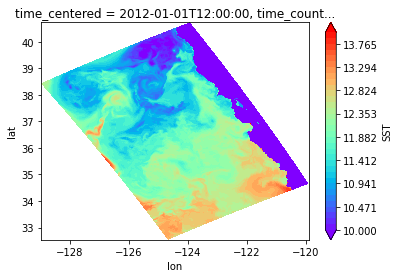

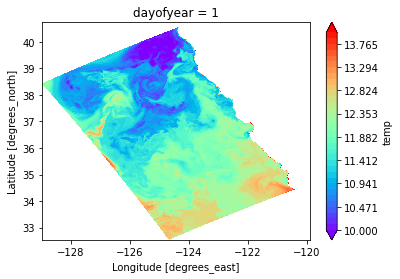

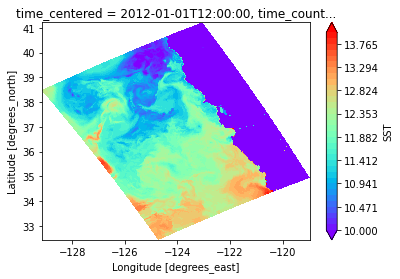

In [42]:
plt.figure()
tf_i[0].plot(x='lon',y='lat',cmap='rainbow',levels=np.linspace(10,14,35))
plt.figure()
tf_croco[0].plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(10,14,35))
plt.figure()
tf_wrf[0].plot(x='nav_lon',y='nav_lat',cmap='rainbow',levels=np.linspace(10,14,35))